# 2024-1 DSL 정규세션 과제

## CNN Assignment

- 작성자 : 윤형진
- 참고자료 : PyTorch Document
- 과제 제출 기한 : 02.18

---
- 이름 : 임창재
- 기수 : 10기



## 해당 과제에는 6개의 섹션과 7개의 문제가 있습니다! 누락없이 제출 부탁드립니다 :)

In [ ]:
!pip install wandb

In [ ]:
# colab 환경에서 학습을 진행하실 분들은 구글드라이브를 연동해주세요
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/[240206]_CNN_ChangjaeIm/scripts

/content/drive/MyDrive/[240206]_CNN_ChangjaeIm/scripts


In [ ]:
# 이번 과제의 일부였던 CustomDataset.py, Model.py를 로드해주세요
from CustomDataset import CustomImageDataset
from Model import ResNet50

import pandas as pd
import numpy as np

import yaml
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
# config.yaml의 위치를 지정해주세요
config_path = "/content/drive/MyDrive/[240206]_CNN_ChangjaeIm/scripts/config.yaml"

# 1. 하이퍼파라미터 및 기타 주요 변수 설정

config.yaml에 지정해줬던 디렉토리, 모델 하이퍼파라미터들을 가져옵시다

In [ ]:
# config.yaml에서 디렉토리, 모델 하이퍼파라미터를 각각 받아옵니다
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

dataset_direc, meta_direc, weight_direc \
    = config["Direc"]["DatasetDirec"], \
      config["Direc"]["MetaDataDirec"], \
      config["Direc"]["WeightDirec"]

epoch, batch_size, lr \
    = config["HyperParameters"]["Epoch"], \
      config["HyperParameters"]["BatchSize"], \
      float(config["HyperParameters"]["LearningRate"])

In [ ]:
import wandb
from signal import signal, SIGPIPE, SIG_DFL
signal(SIGPIPE,SIG_DFL)

# wandb login
wandb.init(
    project="DSL_ResNet", entity='lmnsjae',
    name='DSL_ResNet_lmnsjae_Run',
    config={
        "model_name": 'Resnet_lmnsjae_Aug',
        "epochs": epoch,
        "batch_size": batch_size,
        "lr": lr
    })

config = wandb.config

wandb: Currently logged in as: lmnsjae. Use `wandb login --relogin` to force relogin


In [ ]:
# 가속을 위해 device로 GPU로 설정해줍니다
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. train, val, test DataLoader 초기화

### 문제 1.

모델의 학습을 train, validation, test로 나눠서 진행하는 이유는 무엇인가요?
- (힌트 : 굳이 validation을 끼워넣는 이유는 무엇인가요?)

Overfitting을 방지하기 위해서.

### 문제 2.

모델의 generalization을 높여주기 위해 Augmentation을 사용할 수 있다고 했습니다.

PyTorch 구현상으로는 train, validation, test 모든 단계에 Augmention를 구현할 수 있습니다만, 실제로는 특정 단계에서만 Augmention를 수행하게 됩니다. 어느 단계에서 RandAugment가 적용되어야하는지와, 그 이유에 대해서 설명해주세요.

Train과 Validation 단계에서 Augmentation을 수행해야한다. Augmentation은 학습에 도움을 주기 위한 것이다.

### 문제 3.
CustomImageDataset과 DataLoader 클래스의 차이점에 대해서 설명해주세요.
- (힌트 : 두 클래스의 리턴 형식에 어떤 차이가 있나요? 어디서부터 Batch 단위로 리턴되나요?)

DataLoader 클래스는 CustomImageDataset과 달리 Batch 단위로 리턴한다. 리턴 형식은 Transformation을 어떻게 정의하느냐에 따라 모델에 맞게 조정할 수 있다.

In [ ]:
meta_data = pd.read_csv('/content/drive/MyDrive/[240206]_CNN_ChangjaeIm/scripts/MetaData.csv')

train, val_test = train_test_split(meta_data, train_size=0.6, random_state=777)
val, test = train_test_split(val_test, train_size=0.5, random_state=777)

train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

])

train_dataset = CustomImageDataset(dataset_direc=dataset_direc, df=train, transform = train_transforms)
val_dataset   = CustomImageDataset(dataset_direc=dataset_direc, df=val, transform = train_transforms)
test_dataset  = CustomImageDataset(dataset_direc=dataset_direc, df=test, transform = None)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

# 3. 모델 초기화, 손실함수 및 optimizer 지정

### 문제 4.

주어진 과제는 Binary Classification 태스크입니다.

이중 분류를 위해서는 손실함수로 Binary Cross Entropy를 사용한다고 세션에서 배웠습니다.

PyTorch에는 Binary Cross Entropy를 학습에 사용할 수 있는 2가지 방법이 있는데요, 'nn.BCELoss'와 'nn.BCEWithLogitsLoss'입니다.

이 둘은 같아 보이지만 구현상에서 명백한 차이점이 있습니다.

이 둘의 차이점에 대해서 서술해주세요.

nn.BCEWithLogitsLoss는 BCELoss에 Sigmoid를 추가한 것이다.

In [ ]:
from Model import ResNet50, ResBottleNeck

model = ResNet50(ResBottleNeck, num_channels = 1, num_classes = 1)
model.to(device)

ResNet50(
  (conv_first_layer): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchnorm_first_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool_second_layer): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): ResBottleNeck(
      (conv_first_layer): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (skip_connection): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm_first_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm_skip_connection): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_second_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_second_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_third_layer): Conv2d(64, 256, ker

In [ ]:
from torchsummary import summary
summary(model, (1, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,640
       BatchNorm2d-6          [-1, 256, 56, 56]             512
            Conv2d-7           [-1, 64, 56, 56]           4,160
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,640
      BatchNorm2d-14          [-1, 256,

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 4. Training 시작

학습을 위한 모든 준비가 끝났습니다! ㄱㅂㅈㄱ

### 문제 5.
학습이 끝난 이후 val_loss, train_loss 변화 추이 그래프와 val_acc, train_acc 변화 추이 그래프를 첨부해주세요.
(wandb 대시보드에서 캡쳐하셔도 됩니다)

In [ ]:
best_loss = float("inf")

for curr_epoch in range(epoch+1):
  train_loss = 0
  correct_train = 0

  for img, label in train_loader:
    img, label = img.to(device), label.to(device)
    pred = model(img)
    label = label.view(-1, 1).float()
    loss = criterion(pred, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    pred_class = (torch.sigmoid(pred) > 0.5).float()
    correct_train += (pred_class == label).float().sum()

  train_loss = train_loss/len(train_dataset)
  train_acc = correct_train / len(train_dataset)

  model.eval()

  with torch.no_grad():
    val_loss = 0
    correct_val = 0

    for img, label in val_loader:
      img, label = img.to(device), label.to(device)
      pred = model(img)
      label = label.view(-1, 1).float()
      loss = criterion(pred, label)
      val_loss += loss.item()

      pred_class = (torch.sigmoid(pred) > 0.5).float()
      correct_val += (pred_class == label).float().sum()

    val_loss /= len(val_dataset)
    val_acc = correct_val / len(val_dataset)

  metrics = {
    "epoch": epoch,
    "train_loss": train_loss,
    "val_loss" : val_loss,
    "train_acc": train_acc.item(),
    "val_acc" : val_acc.item(),
    "learning_rate": lr
    }

  wandb.log(metrics)

  model.train()

  if val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), os.path.join(weight_direc, "best_model(aug).pt"))
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## 문제 5.

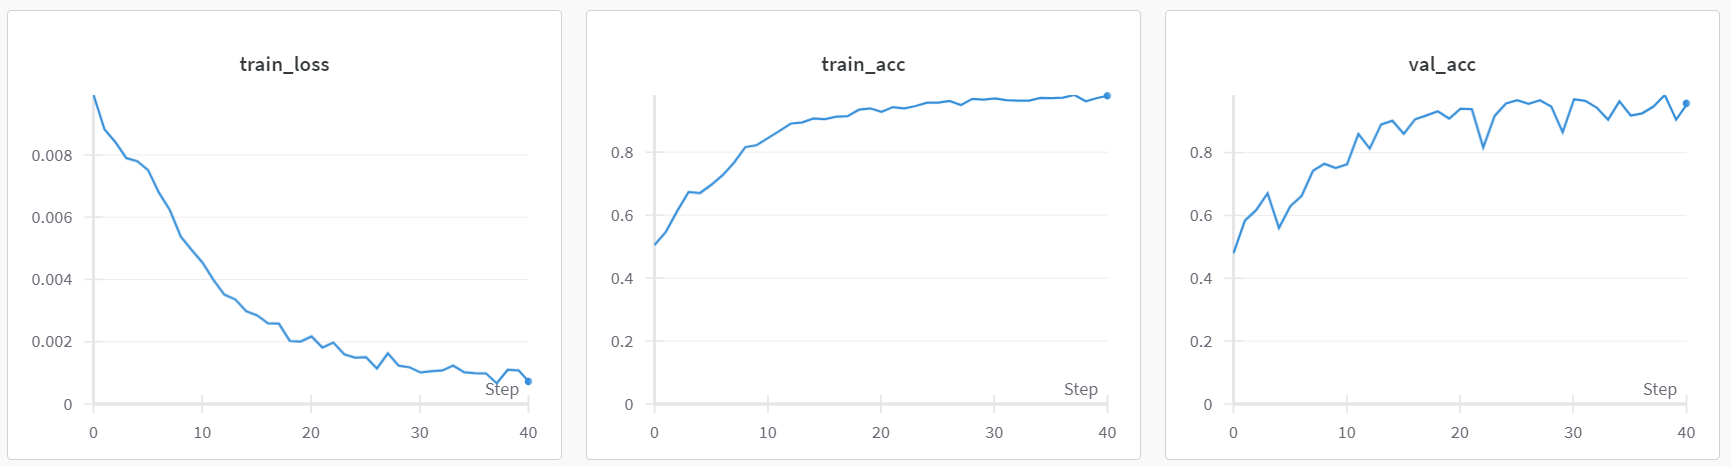

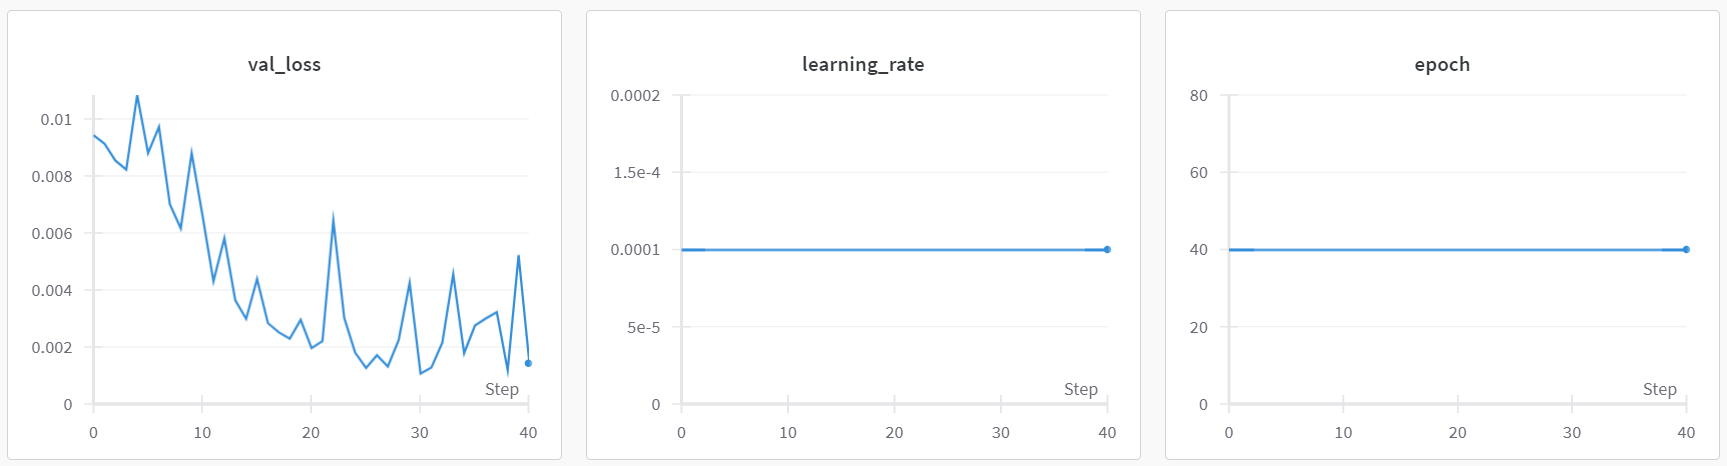

# 5. Test

학습이 모두 끝났다면, 가장 낮은 validation loss를 기록한 모델의 파라미터를 불러오도록합시다.

이후에는 confusion matrix, accuracy 등을 측정하여 모델이 얼마나 잘 학습되었는지 평가하도록 하겠습니다.

### 문제6.

accuracy 95% 이상이 되도록 학습률 등을 조절해주세요.

In [ ]:
trained_model = ResNet50(ResBottleNeck, num_channels = 1, num_classes = 1) # 우선 ResNet50 모델 하나를 초기화 해줍니다
trained_model.load_state_dict(torch.load(os.path.join(weight_direc, "best_model(aug).pt"))) # 아까 저장해둔 weight를 로드해줍니다
trained_model.eval() # 모델을 evaluation 모드로 설정합니다
trained_model.to(device)

ResNet50(
  (conv_first_layer): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchnorm_first_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool_second_layer): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): ResBottleNeck(
      (conv_first_layer): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (skip_connection): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm_first_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm_skip_connection): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_second_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm_second_layer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_third_layer): Conv2d(64, 256, ker

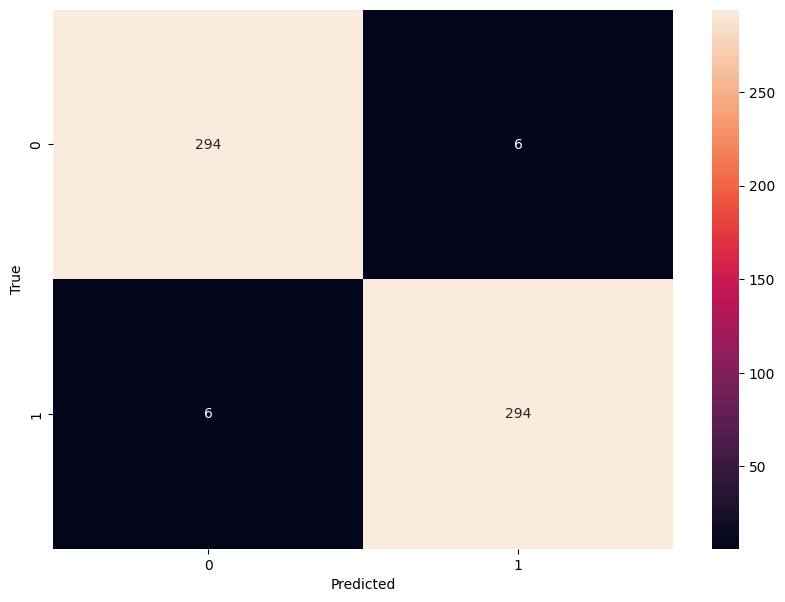

Accuracy: 98.00%


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

all_labels = []
all_predictions = []

for batch_no, (image, label) in enumerate(test_loader):
  image, label = image.to(device), label.to(device)

  with torch.no_grad(): # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    pred = model(image) # 순전파

    probabilities = torch.sigmoid(pred) # 시그모이드 함수를 이용해 확률을 계산합니다
    predicted = (probabilities > 0.5).float()  # 확률을 label로 바꿔줍니다

    all_labels.extend(label.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

# Confusion matrix를 그려줍니다
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy도 출력해봅시다
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

## 문제 6.

Accuracy: 98.00%

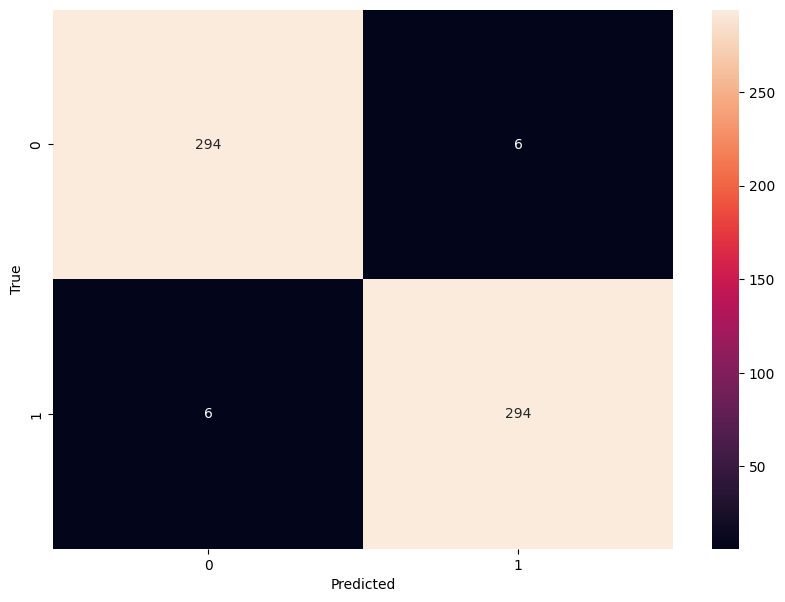

# 6. Augmentation vs No Augmentation

### 문제 7.

전달받으신 파일들 중, Run_NoAugment.ipynb라는 파일이 있을 겁니다.

지금 보고 계신 노트북과 똑같이 학습을 시키시되, 이번에는 학습 시 data augmentation을 적용시키지 않고 진행하십시오.

이후 augmentation을 적용시키지 않은 모델의 train loss와 val loss의 차트를 아래에 붙여놓으시고,

augmentation을 적용한 모델의 학습 양상과 어떤 점이 다른 지와 그 이유도 함께 설명해주세요.

## 문제 7.

Augmentation 을 안 시키면 Train Loss 가 낮게 나올 수도는 있지만 Validation Loss 가 그만큼 낮게 안 나오게 됩니다.

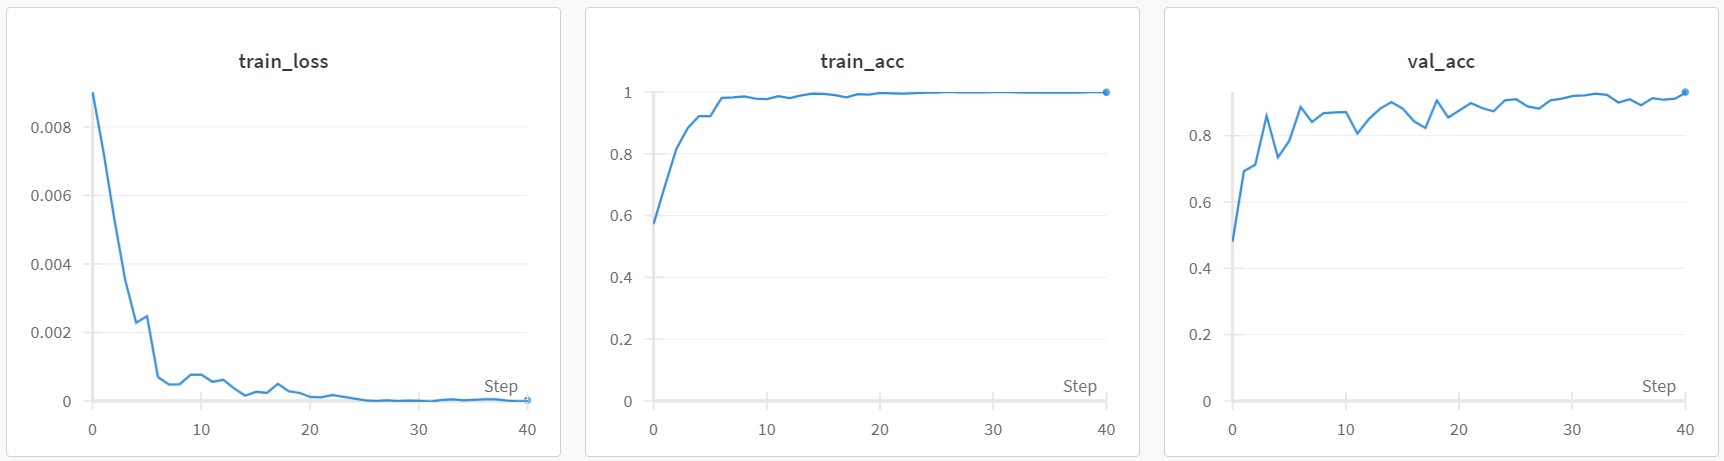

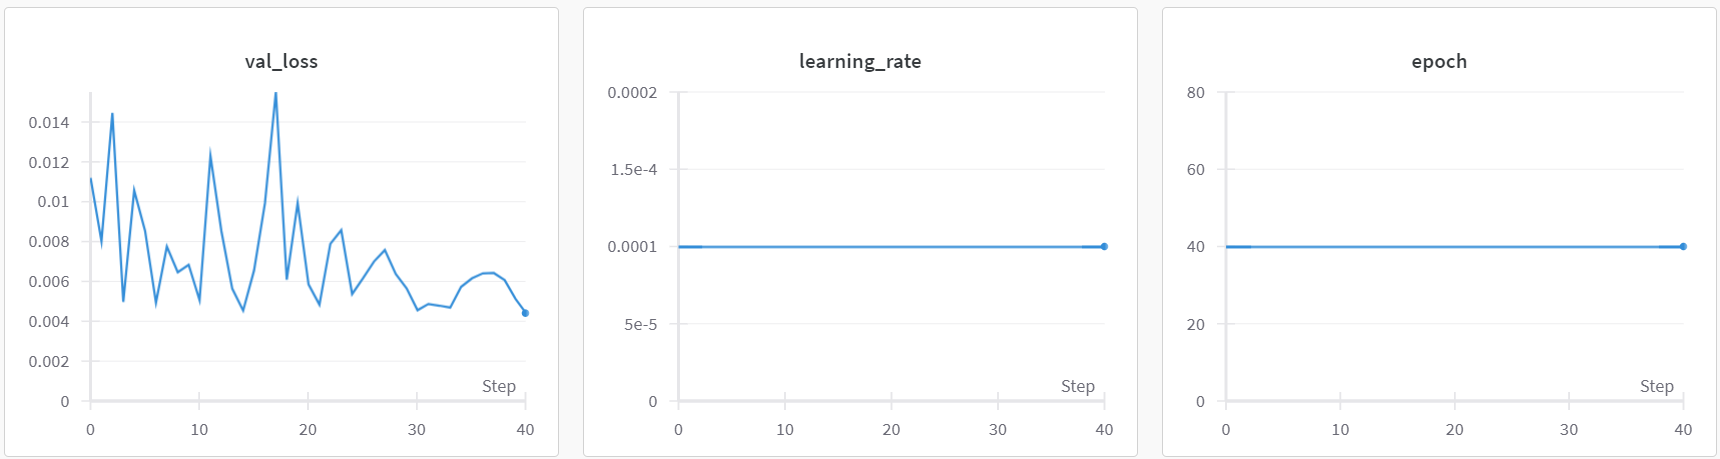